# Machine Learning Photostability

In this notebook, we'll look at data from NV centers and consider their stabilities. The data gives the number of photons emitted per 100ms for different photoemitters. Each of these photoemitters are labeled "Excellent", "Good", "Fair", or "Bad", depending on the stability of their emissions.

We want to be able to predict the stability of a photoemitter after some amount of time

In [2]:
from google.colab import drive
drive.mount('/content/drive')
parent_dir = "/content/drive/MyDrive/photoml"
%cd $parent_dir

Mounted at /content/drive
/content/drive/MyDrive/photoml


In [3]:
import pandas as pd
import tensorflow as tf
import numpy as np
import random
import keras
import matplotlib.pyplot as plt

### Loading in the data from excel

We will classify photoemitters as either "Excellent/Good" or "Fair/Bad"

In [4]:
io = '2019_stability_data_4 classes.xlsx'
num_classes = 2
num_files = 4
pos_list = [0, 1]
# 0 = excellent
# 1 = good
# 2 = fair
# 3 = bad
data = [pd.read_excel(io, sheet_name=i, header=None).to_numpy().transpose() for i in range(num_files)]
min_count, max_count = [f([f(data[i]) for i in range(num_files)]) for f in [np.nanmin, np.nanmax]]

In [5]:
print(min_count, max_count)

830.0 363310.0


Let's look at the min and max times for the data as well as number of examples
We'll trim the data to include time up to t_cutoff, where t_cutoff < min_time.

In [6]:
num_pos = sum([data[i].shape[0] for i in pos_list])
num_neg = sum([data[i].shape[0] for i in range(num_files) if i not in pos_list])

num_examples = num_pos + num_neg
max_time = np.max([data[i].shape[1] for i in range(num_files)])

min_time = max_time
for i in range(num_files):
    for m in range(data[i].shape[0]):
        if np.any(np.isnan(data[i][m])):
            t = np.argwhere(np.isnan(data[i][m]))[0][0]
            min_time = t if t < min_time else min_time

#t_cutoff = int(0.75*min_time)
t_cutoff = max_time

print("num_examples             = {}".format(num_examples))
print("(num_pos , num_neg)      = ({},{})".format(num_pos, num_neg))
print("(min_time, max_time)     = ({},{})".format(min_time, max_time))
print("t_cutoff                 = {}".format(t_cutoff))

num_examples             = 264
(num_pos , num_neg)      = (144,120)
(min_time, max_time)     = (244,599)
t_cutoff                 = 599


Now we prepare the data for training and validation

In [7]:
def clean_data(data, pos_list, t_cutoff, normalize=False):
    all_data = []
    num_files = len(data)
    for i in range(num_files):
        for m in range(data[i].shape[0]):
            t = np.array(data[i][m])
            t = np.pad(t, (0,t_cutoff-len(t))) if t_cutoff > len(t) else t[:t_cutoff]
            t[np.isnan(t)] = 0
            if normalize:
                t  = (t - min_count)/(max_count - min_count)
            label = 1 if i in pos_list else 0
            all_data.append([t,label])

    for i in range(3):
        random.shuffle(all_data)

    all_x, all_y = zip(*all_data)
    all_x, all_y = np.array(all_x), np.array(all_y)
    all_x = np.reshape(all_x, [num_examples, t_cutoff, 1])

    num_train = int(.75*num_examples)
    train_x, train_y = all_x[:num_train], all_y[:num_train]
    test_x , test_y  = all_x[num_train:], all_y[num_train:]
    return train_x, train_y, test_x, test_y

train_x, train_y, test_x, test_y = clean_data(data, pos_list, t_cutoff, True)

Now let's build a simple NN model

In [8]:
def build_RNN(lr):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=4, padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.LSTM(32))
    model.add(tf.keras.layers.Dense(1))
    model.add(tf.keras.layers.LeakyReLU(0.3))

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    loss      = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model        


def train_model(model, train_x, train_y, epochs, batch_size, validation_data=None):
  """Train the model by feeding it data."""

  # Feed the model the feature and the label.
  # The model will train for the specified number of epochs. 
  history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=2,\
                      validation_data=validation_data)
  return history

Next, we train

In [ ]:
epochs = 10000
batch_size = 32
rnn_model = build_RNN(lr=1e-4)
history = train_model(rnn_model, train_x, train_y, epochs, batch_size, validation_data=(test_x, test_y))

Streaming output truncated to the last 5000 lines.
Epoch 8931/100000
7/7 - 0s - loss: 0.6676 - accuracy: 0.4646 - val_loss: 0.6908 - val_accuracy: 0.4394
Epoch 8932/100000
7/7 - 0s - loss: 0.6676 - accuracy: 0.4646 - val_loss: 0.6907 - val_accuracy: 0.4394
Epoch 8933/100000
7/7 - 0s - loss: 0.6676 - accuracy: 0.4646 - val_loss: 0.6903 - val_accuracy: 0.4394
Epoch 8934/100000
7/7 - 0s - loss: 0.6676 - accuracy: 0.4646 - val_loss: 0.6910 - val_accuracy: 0.4394
Epoch 8935/100000
7/7 - 0s - loss: 0.6676 - accuracy: 0.4646 - val_loss: 0.6906 - val_accuracy: 0.4394
Epoch 8936/100000
7/7 - 0s - loss: 0.6675 - accuracy: 0.4646 - val_loss: 0.6904 - val_accuracy: 0.4394
Epoch 8937/100000
7/7 - 0s - loss: 0.6675 - accuracy: 0.4646 - val_loss: 0.6910 - val_accuracy: 0.4394
Epoch 8938/100000
7/7 - 0s - loss: 0.6674 - accuracy: 0.4646 - val_loss: 0.6909 - val_accuracy: 0.4394
Epoch 8939/100000
7/7 - 0s - loss: 0.6682 - accuracy: 0.4596 - val_loss: 0.6916 - val_accuracy: 0.4394
Epoch 8940/100000
7/7 

Now let's see how the training did. First we'll plot the accuracies and losses

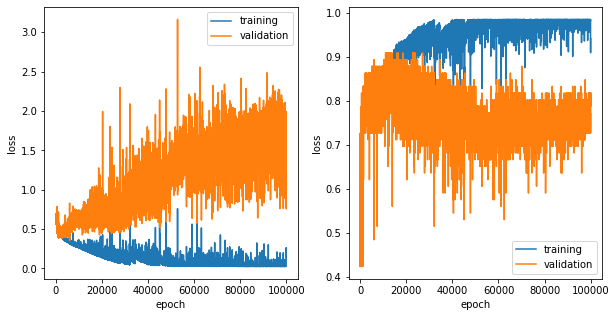

In [ ]:
N = 20
def f(x):
    return np.convolve(x, np.ones(N)/N, 'valid')

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(f(history.history['loss']), label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(loc="best")

plt.subplot(122)
plt.plot(f(history.history['accuracy']), label='training')
plt.plot(history.history['val_accuracy'], label='validation')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(loc="best")
plt.show()

Next, let's look at the confusion matrix

In [ ]:
def get_labels(model, data, threshold=0.5):
    logits = model.predict_on_batch(data)
    p_list  = 1/(1 + np.exp(-logits))
    return (p_list > threshold).astype(int).flatten()

def get_stats(label_y, predi_y):
    TP, FP, TN, FN = 0,0,0,0
    for l, p in zip(label_y, predi_y):
        if l == 1 and p == 1:
            TP += 1
        if l == 1 and p == 0:
            FN += 1
        if l == 0 and p == 1:
            FP += 1
        if l == 0 and p == 0:
            TN += 1
    return TP, FP, TN, FN


In [ ]:
predi_y = get_labels(rnn_model, train_x)
TP, FP, TN, FN = get_stats(train_y, predi_y)
print("Train results")
print("TP = {}".format(TP))
print("TN = {}".format(TN))
print("FP = {}".format(FP))
print("FN = {}".format(FN))
print("")
print("accuracy  = {}".format((TP + TN)/(TP + TN + FP + FN)))
print("precision = {}".format(TP/(TP + FP)))
print("recall    = {}".format(TP/(TP + FN)))

Train results
TP = 103
TN = 84
FP = 8
FN = 3

accuracy  = 0.9444444444444444
precision = 0.9279279279279279
recall    = 0.9716981132075472


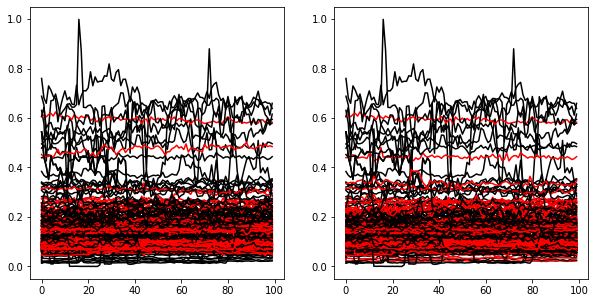

In [ ]:
%matplotlib inline
plt.figure(figsize=(10,5))
plt.subplot(121)
for x, l in zip(train_x, predi_y):
    c = 'r' if l else 'k'
    plt.plot(x.flatten(), c=c)

plt.subplot(122)
for x, l in zip(train_x, train_y):
    c = 'r' if l else 'k'
    plt.plot(x.flatten(), c=c)

plt.show()

In [ ]:
rnn_model.save_weights("rnn_weights_with_val.hdf5")